# Lasso coefficients comparison
---
***Objective:*** The objetive of this notebook is to apply the Lasso regression with several kinds of priors and compare it's coefficients.

***Author:*** Bruno G. de Oliveira

### 1) Importing packages

In [1]:
import sys 
sys.path.append('../')

# Data manipulation 
import pandas as pd 
import numpy as np 
pd.options.display.max_rows=None

# Dataset creation
from dataset.generate_synthetic_data import RegressionData

# Probabilistic programming
import pymc3 as pm 
import theano as T

# Data visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline 

### 2) Create toy dataset

This dataset is built usign scikit-learn function called `make_regression`(https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html#sklearn.datasets.make_regression) which simulates data from a multivariate normal distribution and we can pass as parameters the number of samples, the number of features and the number of informative features that we want.

In [2]:
args = {
    'n_samples': 100,
    'n_features': 50,
    'nonzero_features': 5,
    'seed': 42
}

In [3]:
data = RegressionData(args)
X, y, coefs = data.generate()

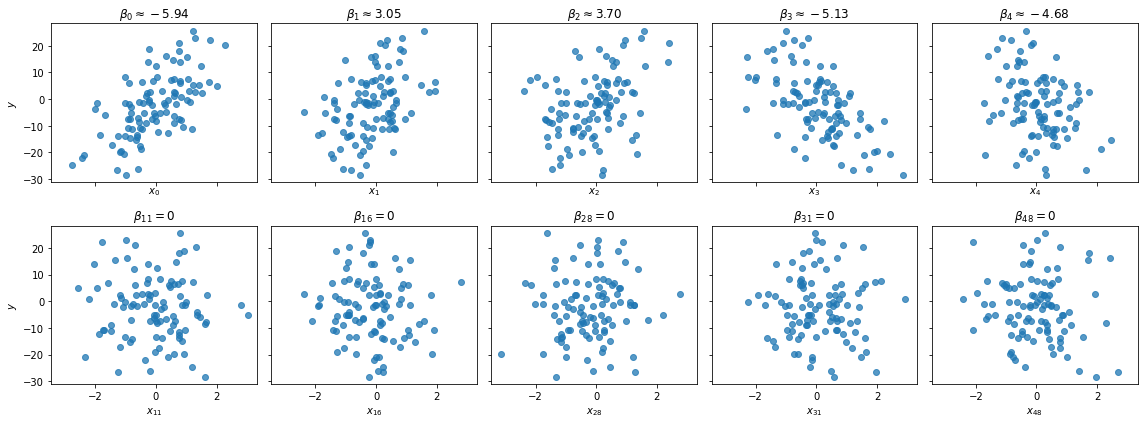

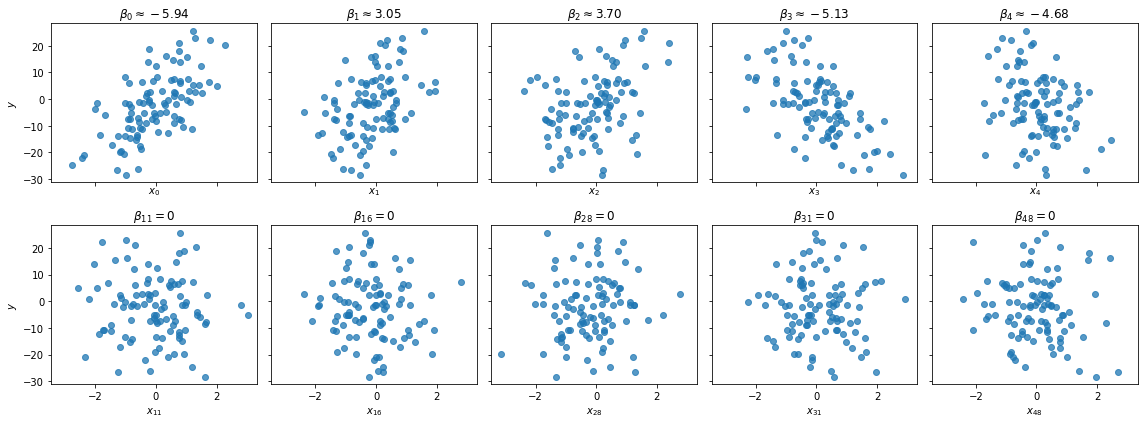

In [4]:
_ = data.plot(X, y, coefs)

In [185]:
# For reproducibility
rng = np.random.default_rng(SEED) 

In [186]:
INTERCEPT = rng.uniform(-3,3)

In [187]:
COEF = np.zeros(N_FEATURES)
COEF[:NONZERO_FEATURES] = rng.choice(
    a=[-1, 1], 
    size=NONZERO_FEATURES
) * rng.normal(5, 1, size=NONZERO_FEATURES)

In [188]:
X = rng.normal(size=(N_SAMPLES, N_FEATURES))

In [189]:
y = INTERCEPT + X.dot(COEF) + rng.normal(0, SIGMA, size=N_SAMPLES)

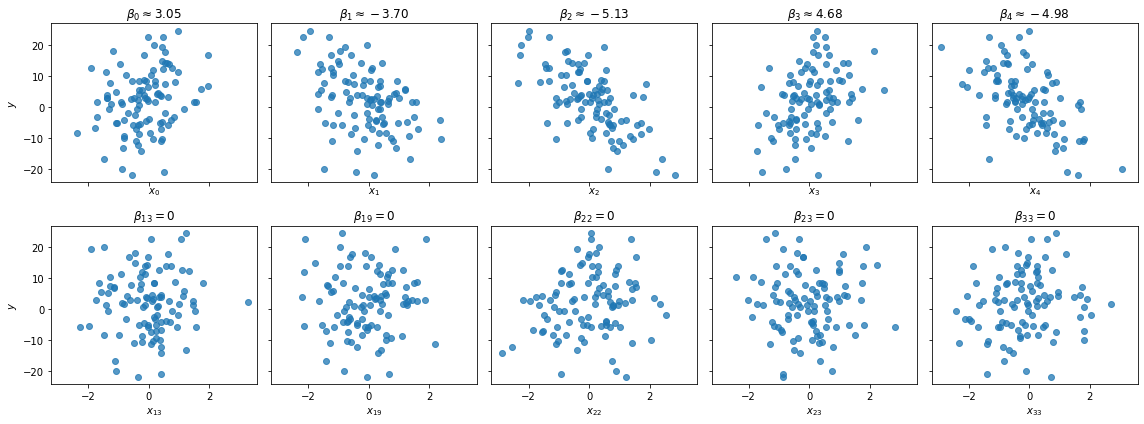

In [190]:
fig, axes = plt.subplots(nrows=2, ncols=NONZERO_FEATURES,
                         sharex=True, sharey=True,
                         figsize=(16, 6))

for i, (ax, coef) in enumerate(zip(axes[0], COEF)):
    ax.scatter(X[:, i], y, alpha=0.75);
    
    ax.set_xlabel(f"$x_{{ {i} }}$");
    ax.set_title(f"$\\beta_{{ {i} }} \\approx {coef:.2f}$");


zero_coef_ix = rng.choice(range(NONZERO_FEATURES, N_FEATURES), replace=False, size=NONZERO_FEATURES)
zero_coef_ix.sort()

for ax, i in zip(axes[1], zero_coef_ix):
    ax.scatter(X[:, i], y, alpha=0.75);
    
    ax.set_xlabel(f"$x_{{ {i} }}$");
    ax.set_title(f"$\\beta_{{ {i} }} = 0$");
    
axes[0, 0].set_ylabel("$y$");
axes[1, 0].set_ylabel("$y$");

fig.tight_layout();

In [142]:
X, y, coef = make_regression(
    n_samples=1000,
    n_features=5,
    n_informative=2,
    coef=True,
    noise=10,
    random_state=42
)

In [143]:
N_SAMPLES, N_FEATURES = X.shape

In [144]:
N_SAMPLES, N_FEATURES

(1000, 5)

### 3) Exploratory data analysis

/Users/bruno.guimaraes/.virtualenvs/dissertacao/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


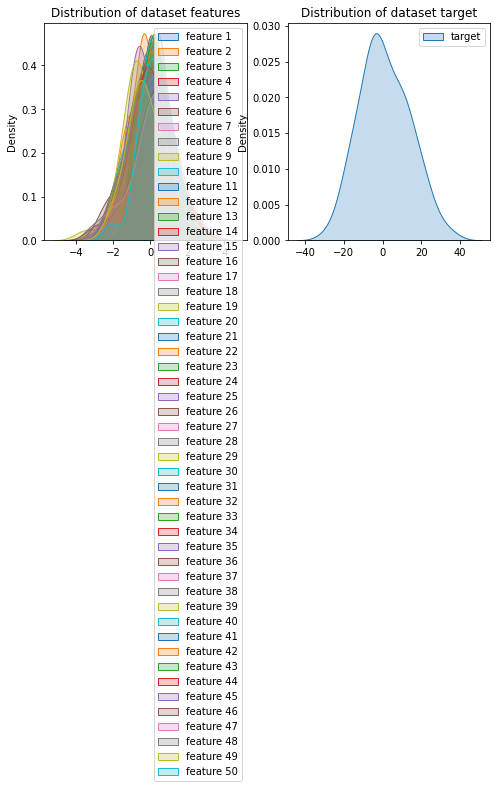

In [170]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), tight_layout=True)

for i in range(X.shape[1]):
    sns.kdeplot(X[i], shade=True, label=f'feature {i + 1}', ax=ax[0])
ax[0].legend()
ax[0].set_title('Distribution of dataset features')

sns.kdeplot(y, shade=True, label='target', ax=ax[1])
ax[1].legend()
ax[1].set_title('Distribution of dataset target');

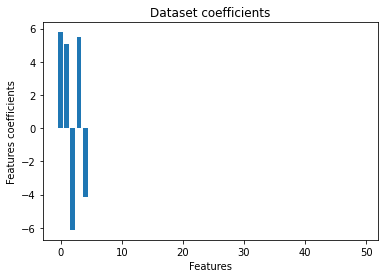

In [181]:
plt.bar(range(COEF.size), COEF)
plt.xlabel('Features')
plt.ylabel('Features coefficients')
plt.title('Dataset coefficients');

### 4) Constructing the models

In [191]:
X_t = T.shared(X)

#### 4.1) Standard bayesian regression:

$Y \sim \mathcal{N}(\mu, \sigma^2)$ \
$\mu = X\beta$

In [192]:
with pm.Model() as bayes_lr:
    
    # prior for intercept 
    βₒ = pm.Normal('intercept', mu=0, sigma=10)
    
    # priors for coefficients
    β = pm.Normal('beta', mu=0, sigma=10, shape=N_FEATURES) 
                          
    # prior for standard deviation
    σ = pm.HalfNormal('sigma', sigma=1)
    
    # observations
    μ = X_t.dot(β) + βₒ 
    y_obs = pm.Normal('obs', mu=μ, sigma=σ, observed=y)
    
    # use MCMC to sample
    trace = pm.sample(draws=500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, intercept]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 29 seconds.


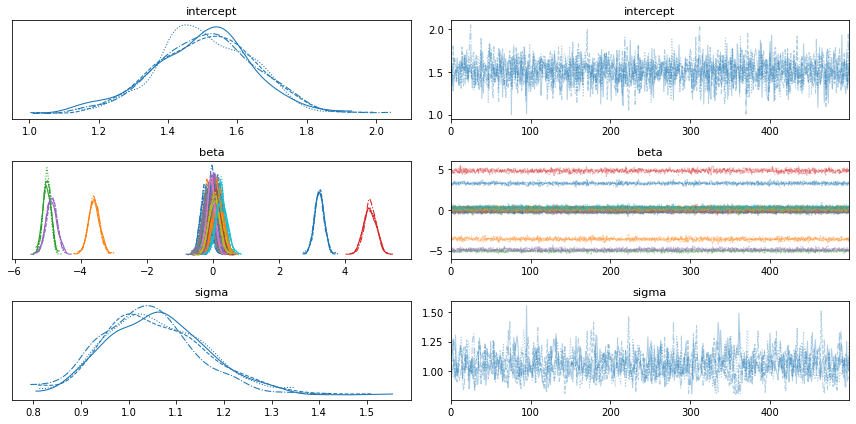

In [193]:
pm.plot_trace(trace)
plt.tight_layout();

In [194]:
trace_summary = pm.summary(trace, round_to=2)
trace_summary[['mean', 'sd', 'hdi_3%', 'hdi_97%']]

,mean,sd,hdi_3%,hdi_97%
intercept,1.51,0.15,1.23,1.78
beta[0],3.22,0.15,2.93,3.49
beta[1],-3.60,0.17,-3.89,-3.26
beta[2],-5.02,0.12,-5.27,-4.80
beta[3],4.75,0.19,4.39,5.08
beta[4],-4.88,0.16,-5.19,-4.58
beta[5],0.04,0.15,-0.24,0.33
beta[6],0.04,0.14,-0.22,0.31
beta[7],0.11,0.13,-0.11,0.37
beta[8],0.10,0.16,-0.21,0.41


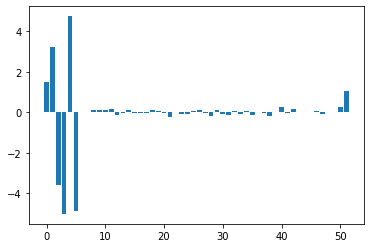

In [198]:
plt.bar(range(trace_summary['mean'].size), trace_summary['mean']);

#### 4.3) Horseshoe

In [200]:
with pm.Model() as horseshoe:
    
    # lambda prior
    λ = pm.HalfCauchy('lambda', beta=1, shape=N_FEATURES)
    
    # tau prior
    τ = pm.HalfCauchy('tau', beta=1)
    
    # Beta standard deviation 
    σ = pm.HalfNormal('sigma', sigma=1)
    
    # Beta prior
    β = pm.Normal('beta', mu=0, sigma=τ*τ*λ*λ, shape=N_FEATURES)
    
    # Intercept prior
    βₒ = pm.Normal('beta_0', mu=0, sigma=1)
    
    μ = X_t.dot(β) + βₒ 
    
    # observations
    y_obs = pm.Normal('obs', mu=μ, sigma=σ, observed=y)

In [207]:
with horseshoe:
    step = pm.NUTS(target_accept=0.99)
    trace = pm.sample(
        draws=1000, 
        return_inferencedata=True, 
        max_treedepth=15, 
        random_seed=42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta, sigma, tau, lambda]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 166 seconds.
There were 807 divergences after tuning. Increase `target_accept` or reparameterize.
There were 820 divergences after tuning. Increase `target_accept` or reparameterize.
There were 817 divergences after tuning. Increase `target_accept` or reparameterize.
There were 999 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.21623073230906326, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


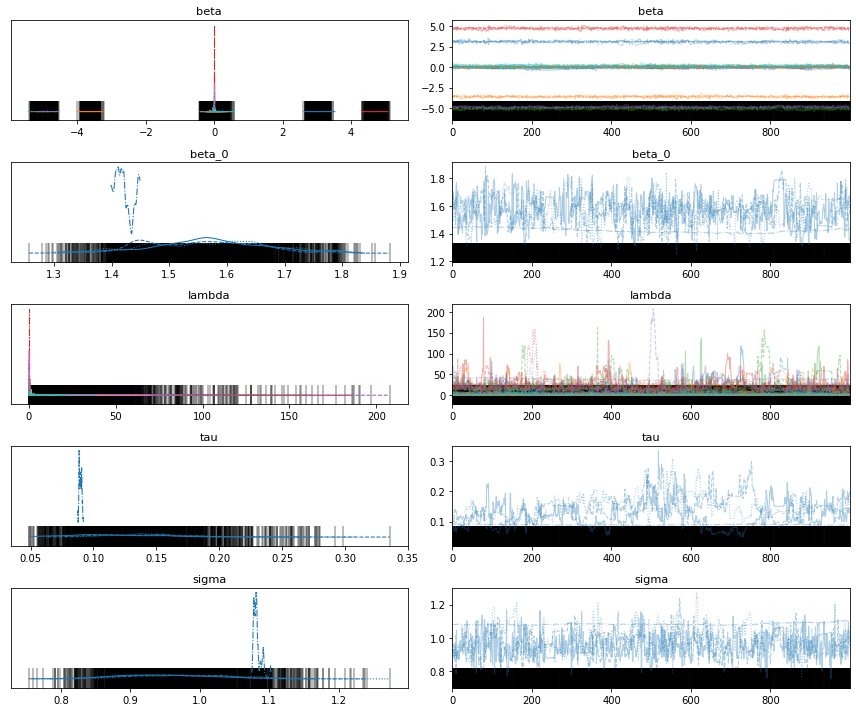

In [208]:
pm.plot_trace(trace)
plt.tight_layout();

In [209]:
trace_summary = pm.summary(trace, round_to=2)
trace_summary[['mean', 'sd', 'hdi_3%', 'hdi_97%']]

,mean,sd,hdi_3%,hdi_97%
beta[0],3.08,0.11,2.86,3.30
beta[1],-3.60,0.10,-3.81,-3.44
beta[2],-5.07,0.10,-5.26,-4.90
beta[3],4.71,0.12,4.47,4.91
beta[4],-4.87,0.09,-5.05,-4.70
beta[5],-0.00,0.01,-0.02,0.02
beta[6],0.03,0.04,-0.03,0.09
beta[7],0.05,0.06,-0.02,0.15
beta[8],0.00,0.03,-0.04,0.06
beta[9],0.01,0.04,-0.03,0.10


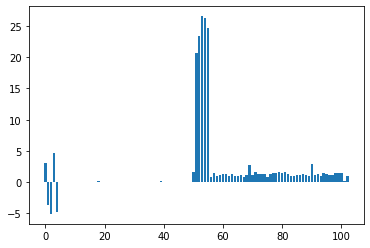

In [206]:
plt.bar(range(trace_summary['mean'].size), trace_summary['mean']);